In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
from pathlib import Path


In [2]:
EXPERIMENT_ROOT = Path('experiments/paper-mlp')
EXPERIMENT_ROOT.mkdir(parents=True, exist_ok=True)


# Loading the dataset

In [3]:
# Load the DRIVE dataset
dataset = Path('../DRIVE')

# Load the training dataset
train_images = sorted(dataset.glob('training/images/*.tif'))
train_labels = sorted(dataset.glob('training/1st_manual/*.gif'))
train_mask = sorted(dataset.glob('training/mask/*.gif'))

In [4]:
len(train_images), train_images[:3], train_labels[:3], train_mask[:3]

(20,
 [PosixPath('../DRIVE/training/images/21_training.tif'),
  PosixPath('../DRIVE/training/images/22_training.tif'),
  PosixPath('../DRIVE/training/images/23_training.tif')],
 [PosixPath('../DRIVE/training/1st_manual/21_manual1.gif'),
  PosixPath('../DRIVE/training/1st_manual/22_manual1.gif'),
  PosixPath('../DRIVE/training/1st_manual/23_manual1.gif')],
 [PosixPath('../DRIVE/training/mask/21_training_mask.gif'),
  PosixPath('../DRIVE/training/mask/22_training_mask.gif'),
  PosixPath('../DRIVE/training/mask/23_training_mask.gif')])

In [5]:
# Load the test dataset
test_images = sorted(dataset.glob('test/images/*.tif'))
test_mask = sorted(dataset.glob('test/mask/*.gif'))
len(test_images), test_images[:3], test_mask[:3]

(20,
 [PosixPath('../DRIVE/test/images/01_test.tif'),
  PosixPath('../DRIVE/test/images/02_test.tif'),
  PosixPath('../DRIVE/test/images/03_test.tif')],
 [PosixPath('../DRIVE/test/mask/01_test_mask.gif'),
  PosixPath('../DRIVE/test/mask/02_test_mask.gif'),
  PosixPath('../DRIVE/test/mask/03_test_mask.gif')])

# Visualizing the dataset

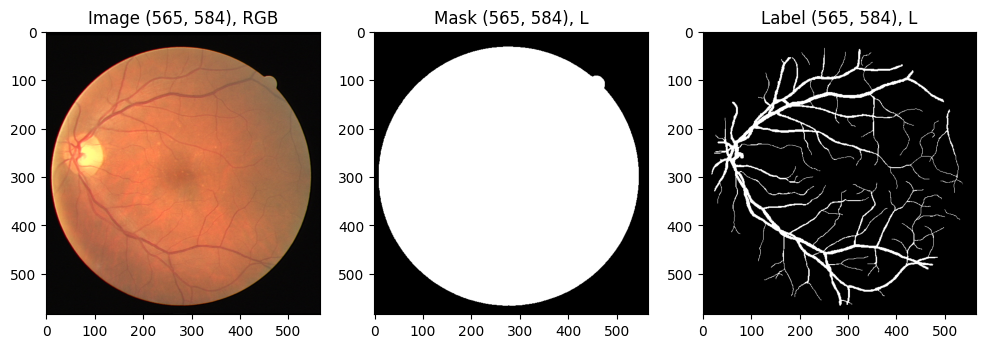

In [6]:
# Display a sample image, mask and label
image = Image.open(train_images[0])
mask = Image.open(train_mask[0])
label = Image.open(train_labels[0])

plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.imshow(image)
plt.title(f'Image {image.size}, {image.mode}')
plt.subplot(132)
plt.imshow(mask, cmap='gray')
plt.title(f'Mask {mask.size}, {mask.mode}')
plt.subplot(133)
plt.imshow(label, cmap='gray')
plt.title(f'Label {label.size}, {label.mode}')
plt.show()


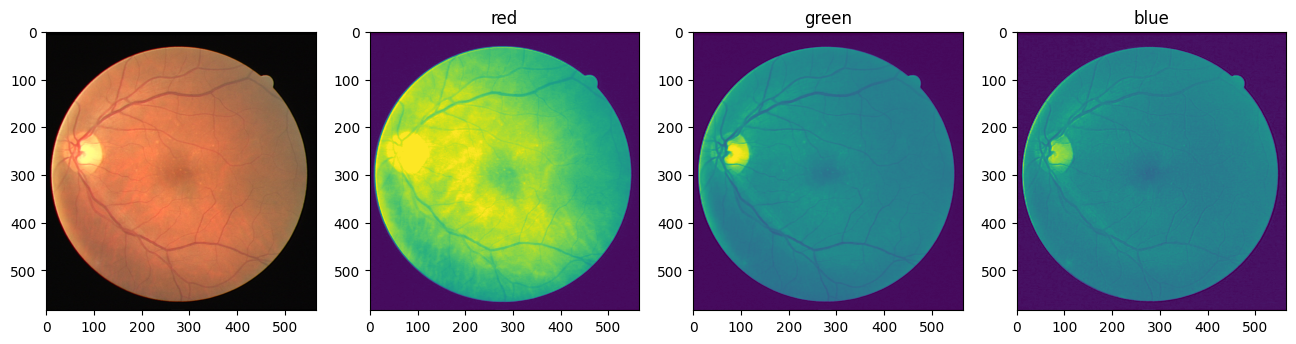

In [7]:
# Displaying the image in R,G,B channels
red, green, blue = image.split()

plt.figure(figsize=(16, 8))
plt.subplot(141)
plt.imshow(image)
plt.subplot(142)
plt.imshow(red)
plt.title('red')
plt.subplot(143)
plt.imshow(green)
plt.title('green')
plt.subplot(144)
plt.imshow(blue)
plt.title('blue')
plt.show()

# Implementing the preprocessing method

In [8]:
# Preprocessing training images

# 1. take only the green channel
# 2. apply morphological opening with a three-pixel diameter disk structuring element
# 3. The local background gray level is computed by applying a 69×69 mean filter to the image. The
# background is then subtracted and the resulting gray levels are scaled from 0 to 1.
# 4. a constant is added to the image gray levels so the mode gray level value in image is set to 0.5
# 5.  top-hat transformation on the complement of the image using an eight-pixel radius
# disk as the structuring element
# 

import numpy as np
from skimage import morphology
from skimage import exposure
from skimage import filters
from skimage import img_as_float32, img_as_ubyte
from skimage import transform

def preprocess(image, mask):
    # Convert the image and mask to float32 tensors
    image = img_as_float32(image)
    mask = img_as_float32(mask)
    
    # Take only the green channel
    image = image[:, :, 1]
    
    # Apply morphological opening with a 3-pixel disk structuring element
    selem = morphology.disk(3)
    image = morphology.opening(image, selem)
    
    # Compute the local mean of the image
    local_mean = filters.rank.mean(image, selem)
    
    # Subtract the local mean from the image
    image = image - local_mean
    
    # Scale the image so that its values range from 0 to 1
    image = exposure.rescale_intensity(image)
    
    # Add a constant to the image so that its minimum value is 0
    image = image - image.min()
    
    # Normalize the image so its values sum to 1
    image = image / image.sum()
    
    # Apply a top-hat transformation to the image
    selem = morphology.disk(8)
    image = morphology.white_tophat(image, selem)
    
    # Normalize the image so its values sum to 1
    image = image / image.sum()
    
    # Apply the mask to the image
    image = image * mask
    
    # # Convert the image and the mask to PyTorch tensors
    # image = torch.from_numpy(image).unsqueeze(0)
    # mask = torch.from_numpy(mask).unsqueeze(0)
    image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX)
    image = img_as_ubyte(image)
    
    return image

/var/folders/6p/sy3vktvj7ls4vmvwmgttgfr00000gn/T/ipykernel_3675/2625198958.py:1: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  p_image = preprocess(image, mask)


(584, 565)


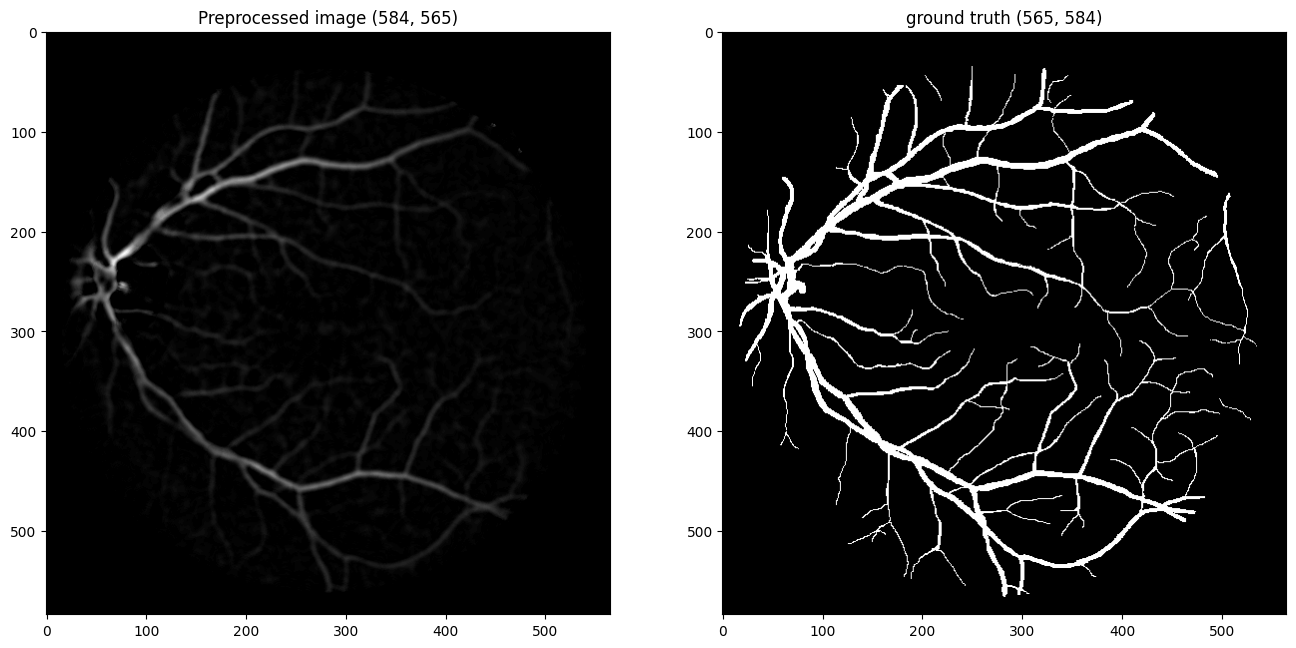

In [9]:
p_image = preprocess(image, mask)
print(p_image.shape)

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title(f'Preprocessed image {p_image.shape}')
plt.imshow(p_image, cmap='gray')
plt.subplot(122)
plt.title(f'ground truth {label.size}')
plt.imshow(label, cmap='gray')
plt.show()

In [10]:
# Feature extraction from preprocessed image
from numpy.lib.stride_tricks import sliding_window_view

windows = sliding_window_view(p_image, (9, 9))
windows.shape



(576, 557, 9, 9)

In [11]:
label_windows = sliding_window_view(label, (9, 9))
label_windows.shape

(576, 557, 9, 9)

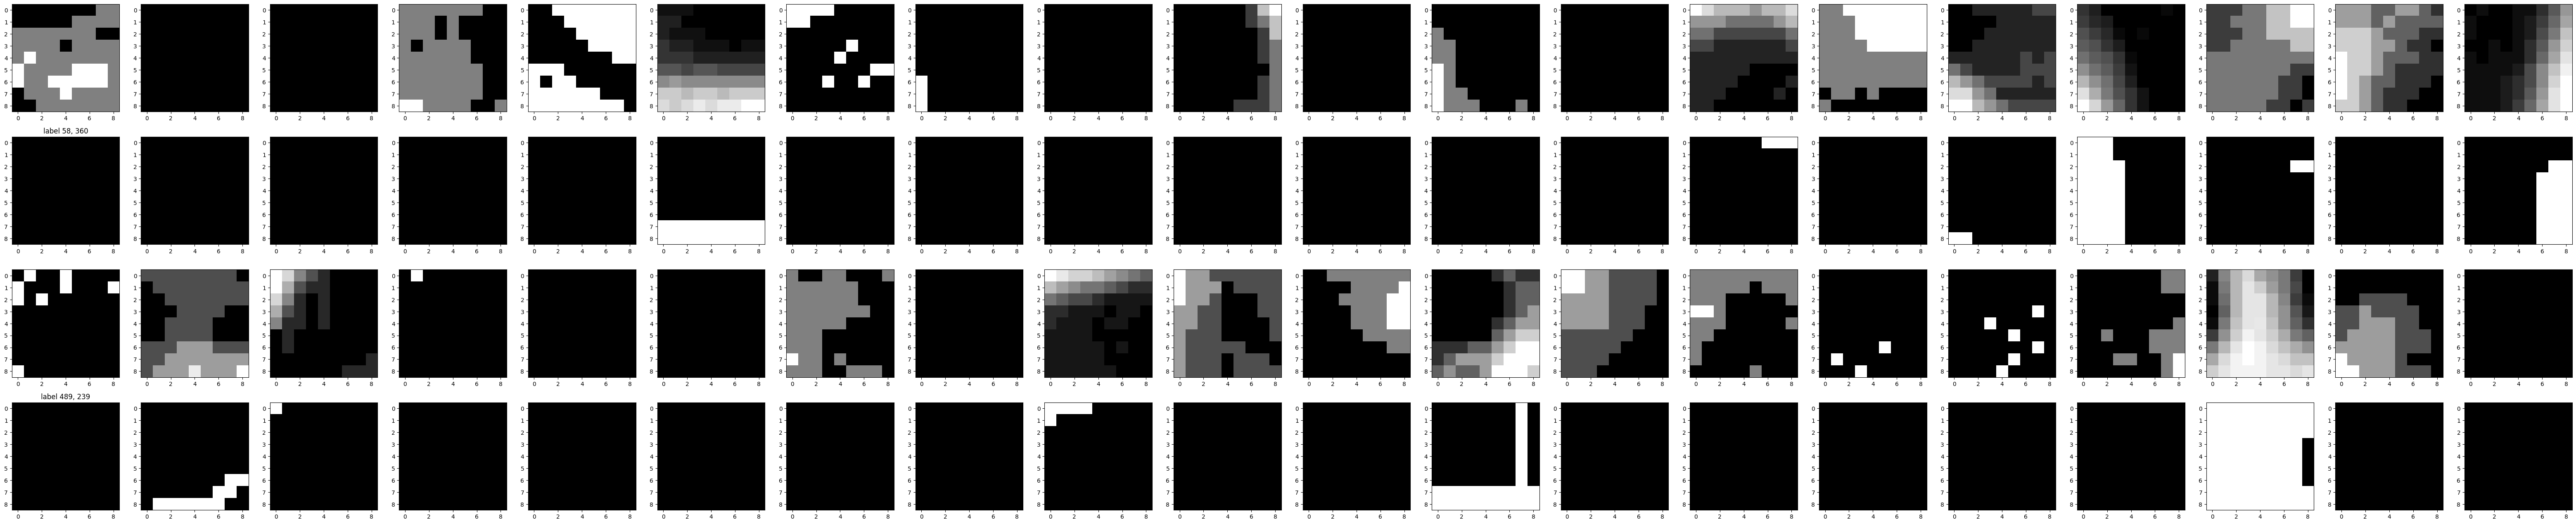

In [12]:
# visualizing the windows randomly

plt.figure(figsize=(80, 16))
for i in range(40):
    xidx = random.randint(0, windows.shape[0]-1)
    yidx = random.randint(0, windows.shape[1]-1)

    if i < 20:
        plt.subplot(4, 20, i+1)
        plt.imshow(windows[xidx, yidx], cmap='gray')

        plt.subplot(4, 20, i+21)
        plt.imshow(label_windows[xidx, yidx], cmap='gray')

        if i == 0:
            plt.title(f'window {xidx}, {yidx}')
            plt.title(f'label {xidx}, {yidx}')

    if i >= 20:
        plt.subplot(4, 20, i-20+41)
        plt.imshow(windows[xidx, yidx], cmap='gray')

        plt.subplot(4, 20, i-20+61)
        plt.imshow(label_windows[xidx, yidx], cmap='gray')

        if i == 20:
            plt.title(f'window {xidx}, {yidx}')
            plt.title(f'label {xidx}, {yidx}')

plt.show()

# Preparing the dataset

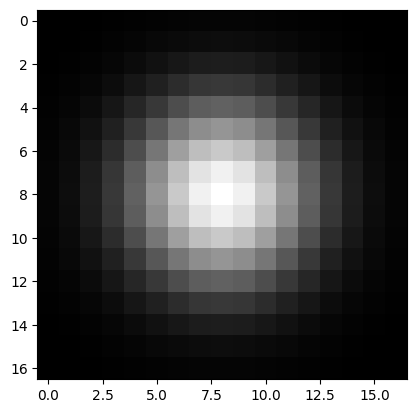

In [13]:
GAUSSIAN_KERNEL = cv2.getGaussianKernel(17, -1)
GAUSSIAN_KERNEL.shape

# make a 2d gaussian filter of size 17x17

gaussian_filter = np.dot(GAUSSIAN_KERNEL, GAUSSIAN_KERNEL.T)
gaussian_filter.shape

# plot the gaussian filter
plt.imshow(gaussian_filter, cmap='gray')
plt.show()

In [14]:
p_image = img_as_float32(p_image)
windows = sliding_window_view(p_image, (17, 17)).copy()
windows.shape

(568, 549, 17, 17)

In [15]:
windows *= gaussian_filter
windows.shape

(568, 549, 17, 17)

In [16]:
hu_zero, hu_one = [], []
for i in range(windows.shape[0]):
    for j in range(windows.shape[1]):
        moments = cv2.moments(windows[i, j], binaryImage=True)
        huMoments = cv2.HuMoments(moments)

        hu0 = np.log10(abs(huMoments[0]) + 1e-6)
        hu1 = np.log10(abs(huMoments[1]) + 1e-6)
        # print(moments)
        # print(huMoments)
        # print(hu0, hu1)
        hu_zero.append(hu0)
        hu_one.append(hu1)

In [17]:
len(hu_zero), len(hu_one)

(311832, 311832)

In [18]:
np_hu0 = np.array(hu_zero).reshape(568, 549)
np_hu1 = np.array(hu_one).reshape(568, 549)
hu_feat = np.stack([np_hu0, np_hu1], axis=-1)
hu_feat = np.pad(hu_feat, 4, mode='constant')
hu_feat.shape

(576, 557, 10)

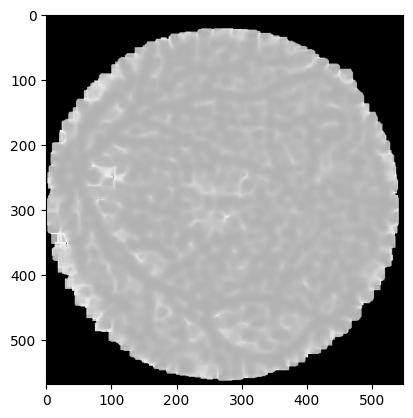

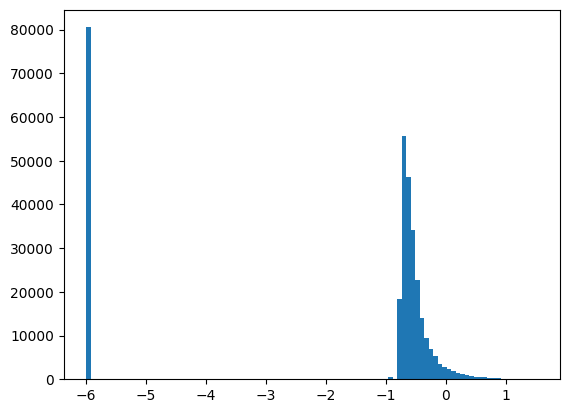

In [19]:
plt.imshow(np_hu0, cmap='gray')
plt.show()
plt.hist(np_hu0.ravel(), bins=100)
plt.show()

In [29]:
# compute the image moments for a region

def compute_moments_feature(p_image):
    p_image = img_as_float32(p_image)
    windows = sliding_window_view(p_image, (17, 17)).copy()

    # multiple each window with gaussian filter
    windows = windows * gaussian_filter

    # calculate hu0 and hu1 moments
    hu_zero, hu_one = [], []
    for i in range(windows.shape[0]):
        for j in range(windows.shape[1]):
            moments = cv2.moments(windows[i, j], binaryImage=True)
            huMoments = cv2.HuMoments(moments)

            hu0 = np.log10(abs(huMoments[0]) + 1e-6)
            hu1 = np.log10(abs(huMoments[1]) + 1e-6)
            hu_zero.append(hu0)
            hu_one.append(hu1)
    np_hu0 = np.array(hu_zero).reshape(568, 549)
    np_hu1 = np.array(hu_one).reshape(568, 549)
    hu_feat = np.stack([np_hu0, np_hu1], axis=-1)
    hu_feat = np.pad(hu_feat, ((4,4), (4,4), (0,0)), mode='constant')
    return hu_feat

In [21]:
# Generating the features of the image
# for each image in the dataset, implement the below steps
# 1. take the image and mask and preprocess the image
# 2. Compute the following features on the preprocessed image, in a 9x9 window around each pixel in the image.
#   a. intensity of center pixel
#  b. absolute difference between the intensity of center pixel and min, max and mean intensity of the window
# c. standard deviation of the window

def extract_features(p_image):
    p_image = img_as_float32(p_image)

    # Compute the window
    windows = sliding_window_view(p_image, (9, 9)).copy()

    # pixel centers
    centers = windows[:, :, 4, 4]

    # min, max, mean, and standard deviation of each window
    w_min, w_max, w_mean, w_std = windows.min(axis=(2, 3)), windows.max(axis=(2, 3)), windows.mean(axis=(2, 3)), windows.std(axis=(2, 3))

    # features
    features = np.stack([centers, np.abs(centers - w_min), np.abs(centers - w_max), np.abs(centers - w_mean), w_std], axis=2)
    
    return features


In [22]:
def extract_labels(label):
    # Compute the window
    windows = sliding_window_view(label, (9, 9)).copy()

    # pixel centers
    centers = windows[:, :, 4, 4]

    # labels
    labels = (centers > 0).astype(np.uint8)
    
    return labels

In [23]:
label_values = extract_labels(label)
label.size, label_values.shape

((565, 584), (576, 557))

In [24]:
for image_path, mask_path, label_path in zip(train_images, train_mask, train_labels):
    print(image_path, mask_path, label_path)

../DRIVE/training/images/21_training.tif ../DRIVE/training/mask/21_training_mask.gif ../DRIVE/training/1st_manual/21_manual1.gif
../DRIVE/training/images/22_training.tif ../DRIVE/training/mask/22_training_mask.gif ../DRIVE/training/1st_manual/22_manual1.gif
../DRIVE/training/images/23_training.tif ../DRIVE/training/mask/23_training_mask.gif ../DRIVE/training/1st_manual/23_manual1.gif
../DRIVE/training/images/24_training.tif ../DRIVE/training/mask/24_training_mask.gif ../DRIVE/training/1st_manual/24_manual1.gif
../DRIVE/training/images/25_training.tif ../DRIVE/training/mask/25_training_mask.gif ../DRIVE/training/1st_manual/25_manual1.gif
../DRIVE/training/images/26_training.tif ../DRIVE/training/mask/26_training_mask.gif ../DRIVE/training/1st_manual/26_manual1.gif
../DRIVE/training/images/27_training.tif ../DRIVE/training/mask/27_training_mask.gif ../DRIVE/training/1st_manual/27_manual1.gif
../DRIVE/training/images/28_training.tif ../DRIVE/training/mask/28_training_mask.gif ../DRIVE/tra

In [32]:
train_features = []

for image_path, mask_path in zip(train_images, train_mask):
    image = Image.open(image_path)
    mask = Image.open(mask_path)

    p_image = preprocess(image, mask)
    print(p_image.shape)
    stat_feat = extract_features(p_image)
    hu_feat = compute_moments_feature(p_image)
    print(stat_feat.shape, hu_feat.shape)
    features = np.concatenate([stat_feat, hu_feat], axis=-1)
    print(features.shape)

    features = np.pad(features, ((4,4), (4,4), (0,0)), mode='constant')
    train_features.append(features)
    print(f'Extracted {features.shape} features from {image_path.name}')


/var/folders/6p/sy3vktvj7ls4vmvwmgttgfr00000gn/T/ipykernel_3675/2250950222.py:7: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  p_image = preprocess(image, mask)


(584, 565)
(576, 557, 5) (576, 557, 2)
(576, 557, 7)
Extracted (584, 565, 7) features from 21_training.tif
(584, 565)
(576, 557, 5) (576, 557, 2)
(576, 557, 7)
Extracted (584, 565, 7) features from 22_training.tif
(584, 565)
(576, 557, 5) (576, 557, 2)
(576, 557, 7)
Extracted (584, 565, 7) features from 23_training.tif
(584, 565)
(576, 557, 5) (576, 557, 2)
(576, 557, 7)
Extracted (584, 565, 7) features from 24_training.tif
(584, 565)
(576, 557, 5) (576, 557, 2)
(576, 557, 7)
Extracted (584, 565, 7) features from 25_training.tif
(584, 565)
(576, 557, 5) (576, 557, 2)
(576, 557, 7)
Extracted (584, 565, 7) features from 26_training.tif
(584, 565)
(576, 557, 5) (576, 557, 2)
(576, 557, 7)
Extracted (584, 565, 7) features from 27_training.tif
(584, 565)
(576, 557, 5) (576, 557, 2)
(576, 557, 7)
Extracted (584, 565, 7) features from 28_training.tif
(584, 565)
(576, 557, 5) (576, 557, 2)
(576, 557, 7)
Extracted (584, 565, 7) features from 29_training.tif
(584, 565)
(576, 557, 5) (576, 557, 2

In [43]:
train_y = []
for label_path in train_labels:
    labels = extract_labels(label)
    print(labels.shape)
    labels = np.pad(labels, 4, mode='constant')
    train_y.append(labels)
    print(f'Extracted {labels.shape} labels from {label_path.name}')

(576, 557)
Extracted (584, 565) labels from 21_manual1.gif
(576, 557)
Extracted (584, 565) labels from 22_manual1.gif
(576, 557)
Extracted (584, 565) labels from 23_manual1.gif
(576, 557)
Extracted (584, 565) labels from 24_manual1.gif
(576, 557)
Extracted (584, 565) labels from 25_manual1.gif
(576, 557)
Extracted (584, 565) labels from 26_manual1.gif
(576, 557)
Extracted (584, 565) labels from 27_manual1.gif
(576, 557)
Extracted (584, 565) labels from 28_manual1.gif
(576, 557)
Extracted (584, 565) labels from 29_manual1.gif
(576, 557)
Extracted (584, 565) labels from 30_manual1.gif
(576, 557)
Extracted (584, 565) labels from 31_manual1.gif
(576, 557)
Extracted (584, 565) labels from 32_manual1.gif
(576, 557)
Extracted (584, 565) labels from 33_manual1.gif
(576, 557)
Extracted (584, 565) labels from 34_manual1.gif
(576, 557)
Extracted (584, 565) labels from 35_manual1.gif
(576, 557)
Extracted (584, 565) labels from 36_manual1.gif
(576, 557)
Extracted (584, 565) labels from 37_manual1.g

In [44]:
train_set = np.stack(train_features), np.stack(train_y)
train_set[0].shape, train_set[1].shape

((20, 584, 565, 7), (20, 584, 565))

In [35]:
# # for all images in test set, extract the features
# test_features = []
# for image_path, mask_path in zip(test_images, test_mask):
#     image = Image.open(image_path)
#     mask = Image.open(mask_path)

#     p_image = preprocess(image, mask)
#     stat_feat = extract_features(p_image)
#     hu_feat = compute_moments_feature(p_image)
#     features = np.concatenate([stat_feat, hu_feat], axis=-1)
#     features = np.pad(features, ((4,4), (4,4), (0,0)), mode='constant')
#     test_features.append(features)
#     print(f'Extracted {features.shape} features from {image_path.name}')

# test_set = np.stack(test_features)
# test_set.shape

/var/folders/6p/sy3vktvj7ls4vmvwmgttgfr00000gn/T/ipykernel_3675/2725497452.py:7: UserWarning: Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  p_image = preprocess(image, mask)


Extracted (584, 565, 7) features from 01_test.tif
Extracted (584, 565, 7) features from 02_test.tif
Extracted (584, 565, 7) features from 03_test.tif
Extracted (584, 565, 7) features from 04_test.tif
Extracted (584, 565, 7) features from 05_test.tif
Extracted (584, 565, 7) features from 06_test.tif
Extracted (584, 565, 7) features from 07_test.tif
Extracted (584, 565, 7) features from 08_test.tif
Extracted (584, 565, 7) features from 09_test.tif
Extracted (584, 565, 7) features from 10_test.tif
Extracted (584, 565, 7) features from 11_test.tif
Extracted (584, 565, 7) features from 12_test.tif
Extracted (584, 565, 7) features from 13_test.tif
Extracted (584, 565, 7) features from 14_test.tif
Extracted (584, 565, 7) features from 15_test.tif
Extracted (584, 565, 7) features from 16_test.tif
Extracted (584, 565, 7) features from 17_test.tif
Extracted (584, 565, 7) features from 18_test.tif
Extracted (584, 565, 7) features from 19_test.tif
Extracted (584, 565, 7) features from 20_test.tif


(20, 584, 565, 7)

In [45]:
# Save and load the train_set and test_set

np.savez_compressed(EXPERIMENT_ROOT / 'train_set.npz', X=train_set[0], y=train_set[1])
# np.savez_compressed(EXPERIMENT_ROOT / 'test_set.npz', X=test_set)

# Sampling postive and negative examples from train_set

In [46]:
# load the train_set and test_set
train_set = np.load(EXPERIMENT_ROOT / 'train_set.npz', allow_pickle=True)
# test_set = np.load(EXPERIMENT_ROOT / 'test_set.npz', allow_pickle=True)

In [47]:
train_set['X'].shape, train_set['y'].shape

((20, 584, 565, 7), (20, 584, 565))

In [48]:
np.unique(train_set['y'], return_counts=True)

(array([0, 1], dtype=uint8), array([6106040,  493160]))

(array([6106040.,       0.,       0.,       0.,       0.,       0.,
              0.,       0.,       0.,  493160.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

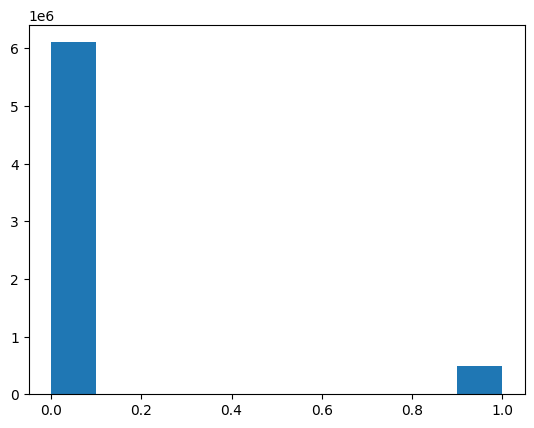

In [49]:
plt.hist(train_set['y'].ravel())

In [57]:
# Positive samples
pos_samples = train_set['X'][train_set['y'] == 1]
pos_samples.shape

(493160, 7)

In [51]:
# Variance of negative samples

neg_samples = train_set['X'][train_set['y'] == 0]
neg_samples.shape


(6106040, 7)

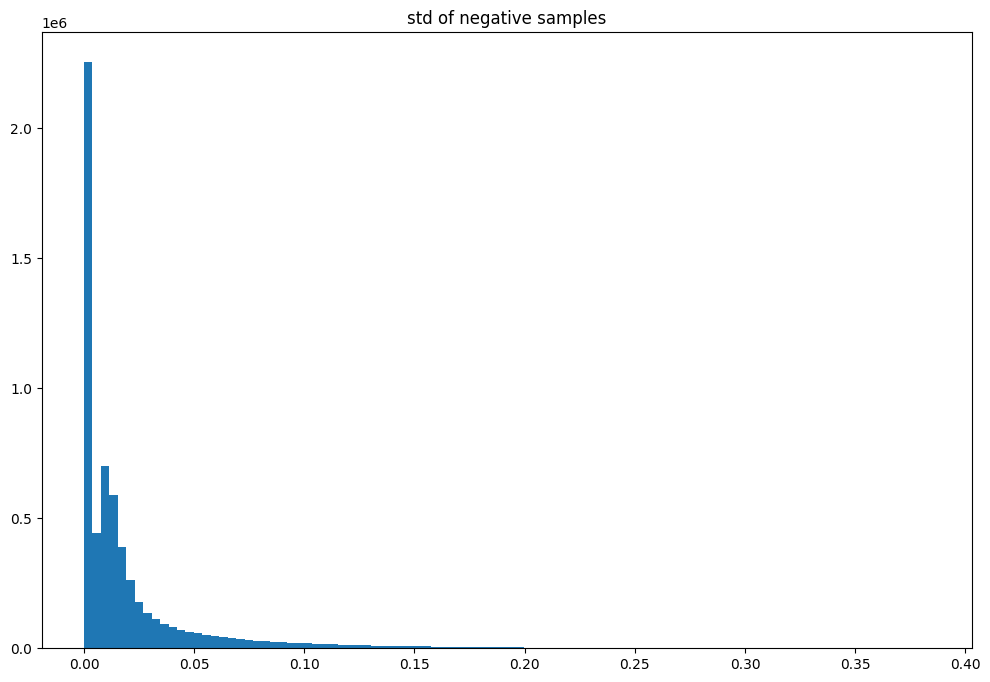

In [54]:
# plotting the std of negative samples
plt.figure(figsize=(12, 8))
plt.hist(neg_samples[:, 4].ravel(), bins=100)
plt.title('std of negative samples')
plt.show()

In [55]:
# sampling the negative samples equal to the number of positive samples
sample_neg_idx = np.random.choice(np.arange(neg_samples.shape[0]), size=train_set['y'].sum())
sample_neg = neg_samples[sample_neg_idx]
sample_neg.shape


(493160, 7)

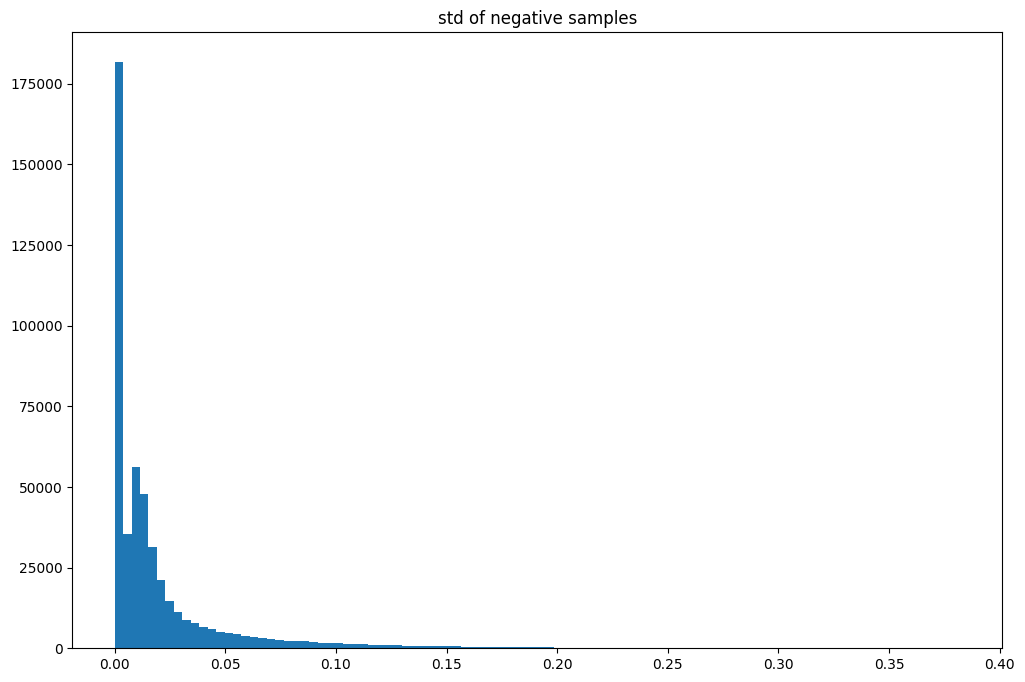

In [59]:
# plotting the std of negative samples
plt.figure(figsize=(12, 8))
plt.hist(sample_neg[:, 4].ravel(), bins=100)
plt.title('std of negative samples')
plt.show()

## Create a balanced dataset for training the Neural Network

In [60]:
# balanced dataset = positive samples + negative samples
balanced_x = np.concatenate([pos_samples, sample_neg], axis=0)
balanced_y = np.concatenate([np.ones(pos_samples.shape[0]), np.zeros(sample_neg.shape[0])], axis=0)
balanced_x.shape, balanced_y.shape
NUM_FEATURES = balanced_x.shape[-1]

In [61]:
# feature scaling of balanced_x
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
balanced_x = scaler.fit_transform(balanced_x.reshape(-1, NUM_FEATURES)).reshape(balanced_x.shape)
balanced_x.shape

(986320, 7)

In [62]:
balanced_y.sum(), np.unique(balanced_y, return_counts=True) 

(493160.0, (array([0., 1.]), array([493160, 493160])))

In [63]:
np.savez_compressed(EXPERIMENT_ROOT / 'balanced_train_set.npz', X=balanced_x, y=balanced_y)

# Training the Neural Network using MLP

In [89]:
import torch
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt

device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device = 'cpu'

In [90]:
NUM_FEATURES = 5

In [91]:
# Pytorch dataloader for balanced data

class DRIVE(Dataset):
    def __init__(self, data_percentage=1.0):
        super().__init__()
        balanced_set = np.load(EXPERIMENT_ROOT / 'balanced_train_set.npz')
        M = int(balanced_set['X'].shape[0] * data_percentage)

        samples = np.random.choice(np.arange(balanced_set['X'].shape[0]), size=M)
        self.X = balanced_set['X'][samples][..., :NUM_FEATURES].astype(np.float32)
        self.y = balanced_set['y'].reshape(-1,1)[samples].astype(np.float32)

        print('Loaded the dataset', self.X.shape, self.X.dtype, self.y.shape, self.y.dtype)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [92]:
# MLP with 5 inputs, three hidden layers with 15 nodes each, and one output


class MLP(nn.Module):
    def __init__(self, input_size=NUM_FEATURES, hidden_size=[15,15,15], output_size=1, dropout=0.5):
        super().__init__()
        self.p_dropout = dropout
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        for i in range(1, len(hidden_size)):
            setattr(self, f'fc{i+1}', nn.Linear(hidden_size[i-1], hidden_size[i]))
        self.fc4 = nn.Linear(hidden_size[-1], output_size)
    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu6(self.fc1(x))
        x = F.relu6(self.fc2(x))
        x = F.relu6(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

In [93]:
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.BCELoss()

print(model)

MLP(
  (fc1): Linear(in_features=5, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=15, bias=True)
  (fc3): Linear(in_features=15, out_features=15, bias=True)
  (fc4): Linear(in_features=15, out_features=1, bias=True)
)


In [94]:

epochs = 10
BATCH_SIZE = 1024
lr = 0.01

train_set = DRIVE(data_percentage=0.1)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

model.train()
for epoch in range(epochs):
    losses = []
    for batch_num, input_data in enumerate(train_loader):
        optimizer.zero_grad()
        x, y = input_data
        x = x.to(device).float()
        y = y.to(device)

        output = model(x)
        loss = criterion(output, y)
        loss.backward()
        losses.append(loss.item())

        optimizer.step()

        if batch_num % 40 == 0:
            print('\tEpoch %d | Batch %d | Loss %6.2f' % (epoch, batch_num, loss.item()))
    print('Epoch %d | Loss %6.2f' % (epoch, sum(losses)/len(losses)))

Loaded the dataset (98632, 5) float32 (98632, 1) float32
	Epoch 0 | Batch 0 | Loss   0.69
	Epoch 0 | Batch 40 | Loss   0.69
	Epoch 0 | Batch 80 | Loss   0.67
Epoch 0 | Loss   0.68
	Epoch 1 | Batch 0 | Loss   0.67
	Epoch 1 | Batch 40 | Loss   0.66
	Epoch 1 | Batch 80 | Loss   0.65
Epoch 1 | Loss   0.65
	Epoch 2 | Batch 0 | Loss   0.64
	Epoch 2 | Batch 40 | Loss   0.64
	Epoch 2 | Batch 80 | Loss   0.62
Epoch 2 | Loss   0.62
	Epoch 3 | Batch 0 | Loss   0.62
	Epoch 3 | Batch 40 | Loss   0.60
	Epoch 3 | Batch 80 | Loss   0.59
Epoch 3 | Loss   0.60
	Epoch 4 | Batch 0 | Loss   0.59
	Epoch 4 | Batch 40 | Loss   0.59
	Epoch 4 | Batch 80 | Loss   0.59
Epoch 4 | Loss   0.59
	Epoch 5 | Batch 0 | Loss   0.57
	Epoch 5 | Batch 40 | Loss   0.59
	Epoch 5 | Batch 80 | Loss   0.58
Epoch 5 | Loss   0.58
	Epoch 6 | Batch 0 | Loss   0.58
	Epoch 6 | Batch 40 | Loss   0.56
	Epoch 6 | Batch 80 | Loss   0.57
Epoch 6 | Loss   0.58
	Epoch 7 | Batch 0 | Loss   0.60
	Epoch 7 | Batch 40 | Loss   0.58
	Epoch 7 | Batc

# Using Pytorch Lightning for training the MLP classifier

In [95]:
from typing import Any
import lightning as L
from torchmetrics import Accuracy, Precision, Recall

class MLPLightning(L.LightningModule):
    def __init__(self, input_size=NUM_FEATURES, hidden_size=[15,15,15], output_size=1, learning_rate=0.01):
        super().__init__()
        self.save_hyperparameters()

        self.lr = learning_rate
        self.fc1 = nn.Linear(input_size, hidden_size[0])
        for i in range(1, len(hidden_size)):
            setattr(self, f'fc{i+1}', nn.Linear(hidden_size[i-1], hidden_size[i]))
        self.fc4 = nn.Linear(hidden_size[-1], output_size)
        self.acc = Accuracy(task='binary', threshold=0.65)
        self.precision = Precision(task='binary', threshold=0.65)
        self.recall = Recall(task='binary', threshold=0.65)

    
    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = F.relu6(self.fc1(x))
        x = F.relu6(self.fc2(x))
        x = F.relu6(self.fc3(x))
        x = torch.sigmoid(self.fc4(x))
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        # print('train', x.shape, y.shape, x.dtype, y.dtype)
        output = self(x)
        loss = F.binary_cross_entropy(output, y)
        acc = self.acc(output, y)
        p = self.precision(output, y)
        r = self.recall(output, y)

        self.log_dict({'train_loss': loss, 'train_acc': acc, 'train_precision': p, 'train_recall': r})
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        # print('val', x.shape, y.shape, x.dtype, y.dtype)
        output = self(x)
        loss = F.binary_cross_entropy(output, y)
        acc = self.acc(output, y)
        p = self.precision(output, y)
        r = self.recall(output, y)

        self.log_dict({'val_loss': loss, 'val_acc': acc, 'val_precision': p, 'val_recall': r})
        return loss
    
    def predict_step(self, batch, batch_idx):
        x, _ = batch
        output = self(x)
        return output

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr, momentum=0.9)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-4)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss'
            }
        }

In [96]:
# Use the PyTorch Lightning Trainer to train the model

from torch.utils.data import random_split

MAX_STEPS = 100 * 800
BATCH_SIZE = 2048 # Maximum batch size that fits on the GPU
SPLIT = 0.8
lr = 0.001

# use 20% of training data for validation
trainval_set = DRIVE(data_percentage=0.5)
train_set_size = int(len(trainval_set) * SPLIT)
val_set_size = len(trainval_set) - train_set_size
print('training set:', train_set_size, 'validation set:', val_set_size)

epochs = int(MAX_STEPS * BATCH_SIZE / train_set_size)
print('training steps:', train_set_size * epochs // BATCH_SIZE)

# split the train set into two
seed = torch.Generator().manual_seed(42)
train_set, val_set = random_split(trainval_set, [train_set_size, val_set_size], generator=seed)

# data loaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=100000, shuffle=False)

# create the model and train
model = MLPLightning()

callbacks = [
    L.pytorch.callbacks.LearningRateMonitor(logging_interval='step'),
    L.pytorch.callbacks.ModelCheckpoint(monitor='val_loss'),
    L.pytorch.callbacks.EarlyStopping(monitor='val_loss', patience=3)
]
trainer = L.Trainer(default_root_dir="models/mlpL", max_epochs=epochs, callbacks=callbacks)
trainer.fit(model, train_loader, val_loader)

# final eval score
trainer.validate(model, val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name      | Type            | Params
----------------------------------------------
0 | fc1       | Linear          | 90    
1 | fc2       | Linear          | 240   
2 | fc3       | Linear          | 240   
3 | fc4       | Linear          | 16    
4 | acc       | BinaryAccuracy  | 0     
5 | precision | BinaryPrecision | 0     
6 | recall    | BinaryRecall    | 0     
----------------------------------------------
586       Trainable params
0         Non-trainable params
586       Total params
0.002     Total estimated model params size (MB)


Loaded the dataset (493160, 5) float32 (493160, 1) float32
training set: 394528 validation set: 98632
training steps: 79945


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/krishna.py/miniconda/envs/torch-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/krishna.py/miniconda/envs/torch-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.5358200073242188
        val_loss            0.5762332081794739
      val_precision         0.6789218187332153
       val_recall           0.13870105147361755
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 0.5762332081794739,
  'val_acc': 0.5358200073242188,
  'val_precision': 0.6789218187332153,
  'val_recall': 0.13870105147361755}]

# Visualize Prediction of the model

In [97]:
# model = MLPLightning.load_from_checkpoint('models/mlpL/lightning_logs/version_8/checkpoints/epoch=21-step=8492.ckpt')
# model.eval()

In [98]:
# Training used a balanced dataset. For prediction we will use the full dataset train_set

class PredictDrive(Dataset):
    def __init__(self, num_samples=20):
        super().__init__()
        full_set = np.load(EXPERIMENT_ROOT / 'train_set.npz')
        data_samples = full_set['X'].shape[0]

        self.feature_shape = (min(num_samples, data_samples),) + full_set['X'].shape[1:]
        self.X = full_set['X'][:num_samples][..., :NUM_FEATURES].reshape(-1,NUM_FEATURES).astype(np.float32)
        self.y = full_set['y'][:num_samples].reshape(-1,1).astype(np.float32)

        print(f'Loaded the dataset {self.feature_shape}', self.X.shape, self.X.dtype, self.y.shape, self.y.dtype)
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [99]:
predict_set = PredictDrive(num_samples=20)
predict_loader = DataLoader(predict_set, batch_size=len(predict_set), shuffle=False)

Loaded the dataset (20, 584, 565, 7) (6599200, 5) float32 (6599200, 1) float32


In [100]:
trainer = L.Trainer()
prediction = trainer.predict(model, predict_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/krishna.py/miniconda/envs/torch-env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [101]:
predicted_y = prediction[0].numpy().reshape(predict_set.feature_shape[:-1])

In [102]:
predicted_y.shape

(20, 584, 565)

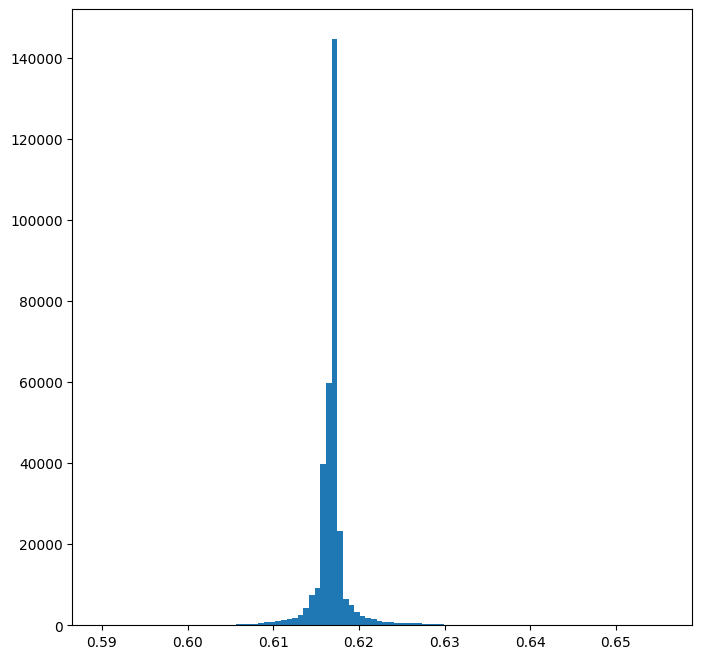

In [103]:
plt.figure(figsize=(8, 8))
plt.hist(predicted_y[0].ravel(), bins=100)
plt.show()

In [104]:
np.histogram(predicted_y[0].ravel(), bins=10)

(array([   131,    582,   3297,  69785, 249210,   5324,   1292,    241,
            61,     37]),
 array([0.589845  , 0.5964228 , 0.6030006 , 0.6095784 , 0.61615616,
        0.62273395, 0.6293117 , 0.6358895 , 0.64246726, 0.64904505,
        0.65562284], dtype=float32))

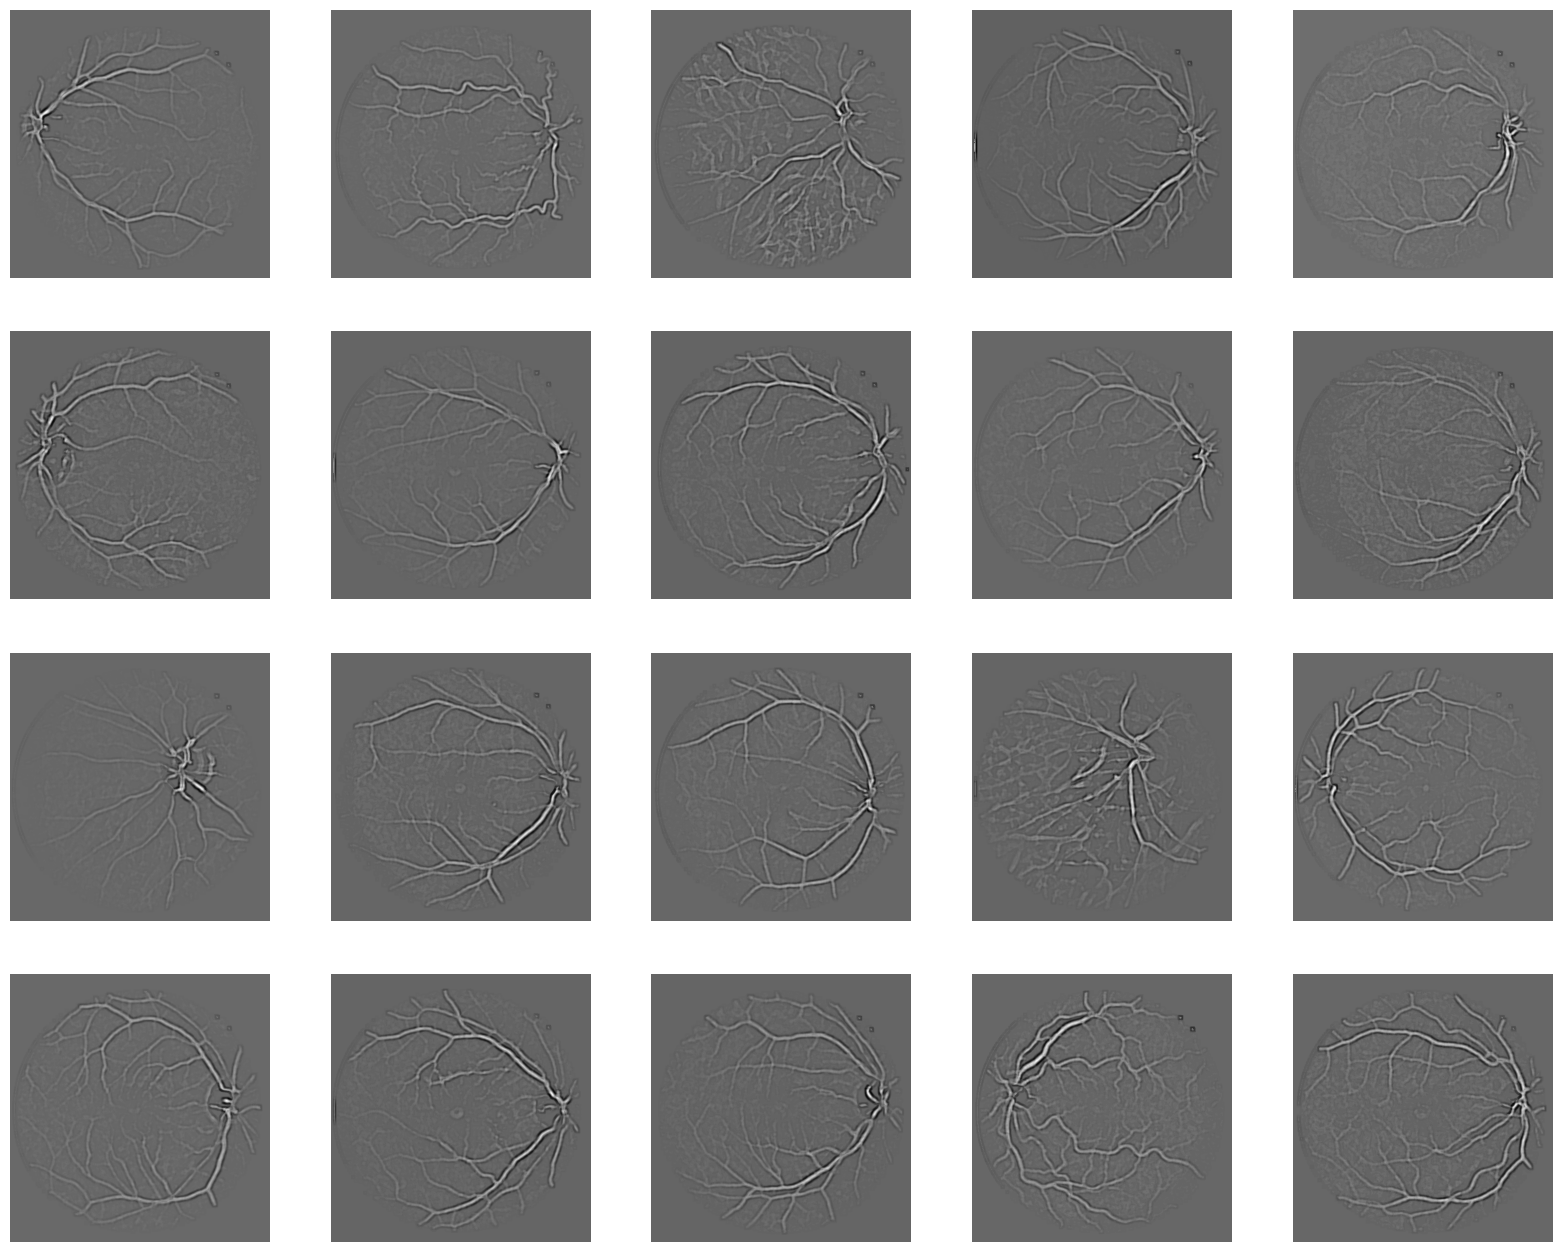

In [105]:
# plot all the 20 images in the test set

plt.figure(figsize=(20, 16))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(predicted_y[i], cmap='gray')
    plt.axis('off')
plt.show()

# Saving the predicted files to numpy for hybrid approach

In [106]:
predicted_y[i].shape

(584, 565)

In [107]:
np.min(predicted_y[i]), np.max(predicted_y[i])

(0.58866763, 0.65856373)

(array([1.00000e+00, 5.00000e+00, 9.00000e+00, 1.10000e+01, 2.30000e+01,
        2.20000e+01, 1.70000e+01, 2.90000e+01, 5.20000e+01, 5.40000e+01,
        8.50000e+01, 1.14000e+02, 1.54000e+02, 1.72000e+02, 2.28000e+02,
        2.59000e+02, 2.57000e+02, 3.06000e+02, 3.54000e+02, 3.84000e+02,
        4.35000e+02, 5.31000e+02, 7.15000e+02, 8.09000e+02, 8.36000e+02,
        1.06200e+03, 1.12100e+03, 1.27600e+03, 1.68200e+03, 1.67200e+03,
        1.64300e+03, 2.66100e+03, 2.19600e+03, 2.74100e+03, 4.59100e+03,
        7.41100e+03, 1.20310e+04, 1.81330e+04, 1.46850e+04, 5.74130e+04,
        1.26075e+05, 1.02190e+04, 2.11640e+04, 6.86300e+03, 5.55400e+03,
        3.36100e+03, 2.08600e+03, 2.29900e+03, 1.74500e+03, 1.54000e+03,
        1.38900e+03, 1.24900e+03, 1.10300e+03, 1.10000e+03, 7.91000e+02,
        7.77000e+02, 6.70000e+02, 5.83000e+02, 5.32000e+02, 4.12000e+02,
        4.90000e+02, 4.21000e+02, 3.72000e+02, 3.31000e+02, 2.81000e+02,
        3.23000e+02, 2.65000e+02, 2.15000e+02, 2.21

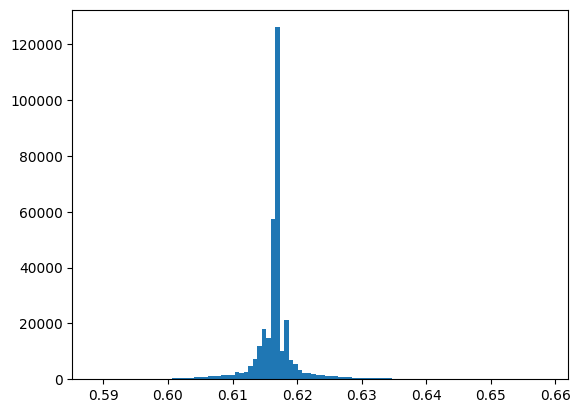

In [108]:
plt.hist(predicted_y[i].ravel(), bins=100)

In [109]:
save_path = EXPERIMENT_ROOT / 'predicted'
save_path.mkdir(parents=True, exist_ok=True)
for i in range(20):
    save_file = save_path / f'yhat_{i+1}.npy'
    np.save(save_file, predicted_y[i])
